# Auditing a Causal Language Model (LM) using the Population Attack

<table class="tfo-notebook-buttons" align="left">
<td>
    <a target="_blank" href="https://colab.research.google.com/github/privacytrustlab/ml_privacy_meter/blob/master/advanced/hf_causal_language_models.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/privacytrustlab/ml_privacy_meter/blob/master/advanced/hf_causal_language_models.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View GitHub</a>
  </td>
</table>

## Imports

In [1]:
import sys
import numpy as np
import torch
from typing import List, Tuple

In [2]:
!{sys.executable} -m pip install datasets
!{sys.executable} -m pip install transformers
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer, TrainingArguments, Trainer

     |████████████████████████████████| 452 kB 15.2 MB/s eta 0:00:01
  Using cached aiohttp-3.8.3-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.0 MB)
  Using cached responses-0.18.0-py3-none-any.whl (38 kB)
  Using cached multiprocess-0.70.14-py39-none-any.whl (132 kB)
  Using cached PyYAML-6.0-cp39-cp39-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (661 kB)
  Using cached huggingface_hub-0.11.1-py3-none-any.whl (182 kB)
  Using cached xxhash-3.1.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (212 kB)
  Using cached fsspec-2022.11.0-py3-none-any.whl (139 kB)
     |████████████████████████████████| 114 kB 14.4 MB/s eta 0:00:01
  Using cached async_timeout-4.0.2-py3-none-any.whl (5.8 kB)
  Using cached frozenlist-1.3.3-cp39-cp39-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (158 kB)
  Using cached aiosignal-1.3.1-py3-none-any.whl (7.6 kB)
     |████████████████████████████████| 264 k

In [44]:
!{sys.executable} -m pip install -e ../.
from privacy_meter.audit import Audit
from privacy_meter.dataset import Dataset
from privacy_meter.hypothesis_test import threshold_func
from privacy_meter.information_source import InformationSource
from privacy_meter.information_source_signal import Signal
from privacy_meter.model import Model
from privacy_meter.metric import PopulationMetric
from privacy_meter.constants import InferenceGame
from privacy_meter.audit_report import ROCCurveReport, SignalHistogramReport



Obtaining file:///home/hongyan/Desktop/upgrade_privacy_meter/ml_privacy_meter
  Attempting uninstall: privacy-meter
    Found existing installation: privacy-meter 1.0
    Uninstalling privacy-meter-1.0:
      Successfully uninstalled privacy-meter-1.0
  Running setup.py develop for privacy-meter


## Hyperparameters

In [4]:
# a toy example for the population metric
num_train_seqs = 25
num_test_seqs = 25
num_population_seqs = 100
fpr_tolerance_list = [0.0, 0.1, 0.5, 0.9, 1.0]

## Load dataset and model using HuggingFace 

### Load and split dataset

In [5]:
# download dataset from huggingface
hf_dataset = load_dataset("wikitext", "wikitext-2-raw-v1")

# remove empty rows
hf_dataset = hf_dataset.filter(lambda elem: len(elem["text"]) > 0)

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

Dataset wikitext downloaded and prepared to /home/hongyan/.cache/huggingface/datasets/wikitext/wikitext-2-raw-v1/1.0.0/a241db52902eaf2c6aa732210bead40c090019a499ceb13bcbfa3f8ab646a126. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

12/21/2022 20:27:59:WARNING:Parameter 'function'=<function <lambda> at 0x7f6a3ae289d0> of the transform datasets.arrow_dataset.Dataset.filter@2.0.1 couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/37 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

### Load and finetune model

In [6]:
# load pretrained and tokenizer
model_id = "distilgpt2"
tokenizer = AutoTokenizer.from_pretrained(model_id, use_fast=True)
model_obj = AutoModelForCausalLM.from_pretrained(model_id)

Downloading:   0%|          | 0.00/762 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/353M [00:00<?, ?B/s]

We tokenize and group the dataset before finetuning the model:

In [7]:
def tokenize_fn(examples):
    return tokenizer(examples["text"])

tokenized_hf_dataset = hf_dataset.map(
    tokenize_fn, batched=True, num_proc=2, remove_columns=["text"]
)

#0:   0%|          | 0/2 [00:00<?, ?ba/s]

#1:   0%|          | 0/2 [00:00<?, ?ba/s]

#0:   0%|          | 0/12 [00:00<?, ?ba/s]

#1:   0%|          | 0/12 [00:00<?, ?ba/s]

#0:   0%|          | 0/2 [00:00<?, ?ba/s]

#1:   0%|          | 0/2 [00:00<?, ?ba/s]

In [8]:
block_size = 128
def group_texts(examples):
    # Concatenate all texts.
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    
    total_length = (total_length // block_size) * block_size
    
    # Split by chunks of max_len.
    result = {
        k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
        for k, t in concatenated_examples.items()
    }
    
    result["labels"] = result["input_ids"].copy()
    return result

lm_hf_dataset = tokenized_hf_dataset.map(
    group_texts, batched=True, batch_size=64, num_proc=2
)

#0:   0%|          | 0/23 [00:00<?, ?ba/s]

#1:   0%|          | 0/23 [00:00<?, ?ba/s]

#0:   0%|          | 0/186 [00:00<?, ?ba/s]

#1:   0%|          | 0/186 [00:00<?, ?ba/s]

#0:   0%|          | 0/20 [00:00<?, ?ba/s]

#1:   0%|          | 0/20 [00:00<?, ?ba/s]

In [9]:
finetune_args = TrainingArguments(num_train_epochs=5, output_dir="privacy_meter_logs/")

In [10]:
hf_trainer = Trainer(
    model=model_obj,
    args=finetune_args,
    train_dataset=lm_hf_dataset["train"].select(range(num_train_seqs)),
    eval_dataset=lm_hf_dataset["validation"]
)

hf_trainer.train()

/home/hongyan/.conda/envs/privacy_meter/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 25
  Num Epochs = 5
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 10
  Number of trainable parameters = 81912576
/home/hongyan/.conda/envs/privacy_meter/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=10, training_loss=4.060710144042969, metrics={'train_runtime': 4.0222, 'train_samples_per_second': 31.077, 'train_steps_per_second': 2.486, 'total_flos': 4082761728000.0, 'train_loss': 4.060710144042969, 'epoch': 5.0})

## Extend Privacy Meter to work with HuggingFace Causal LMs

### Extend the Model class

In [20]:
class HfCausalLMModel(Model):
    """Inherits of the Model class, an interface to query a model without any assumption on how it is implemented.
    This particular class is to be used with HuggingFace Causal LM models.
    """

    def __init__(self, model_obj, loss_fn, stride=64):
        """Constructor
        Args:
            model_obj: model object
            loss_fn: loss function
            stride: window size that will be used by the fixed length 
            causal model for processing an input sequence
        """

        # Initializes the parent model
        super().__init__(model_obj, loss_fn)
        
        self.stride = stride
        
    def get_outputs(self, batch_samples):
        """Function to get the model output from a given input.
        Args:
            batch_samples: Model input
        Returns:
            Model output
        """
        pass

    def get_loss(self, batch_samples, batch_labels):
        """Function to get the model loss on a given input and an expected output.
        Args:
            batch_samples: Model input
            batch_labels: Model expected output
        Returns:
            The loss value, as defined by the loss_fn attribute.
        """
        pass

    def get_logits(self, batch_samples):
        return super().get_logits(batch_samples)
    def get_grad(self, batch_samples, batch_labels):
        """Function to get the gradient of the model loss with respect to the model parameters, on a given input and an
        expected output.
        Args:
            batch_samples: Model input
            batch_labels: Model expected output
        Returns:
            A list of gradients of the model loss (one item per layer) with respect to the model parameters.
        """
        pass

    def get_intermediate_outputs(self, layers, batch_samples, forward_pass=True):
        """Function to get the intermediate output of layers (a.k.a. features), on a given input.
        Args:
            layers: List of integers and/or strings, indicating which layers values should be returned
            batch_samples: Model input
            forward_pass: Boolean indicating if a new forward pass should be executed. If True, then a forward pass is
                executed on batch_samples. Else, the result is the one of the last forward pass.
        Returns:
            A list of intermediate outputs of layers.
        """
        pass
    
    def get_perplexity(self, batch_samples):
        """Function to get the perplexity of the model loss, on a given input sequence.
        Args:
            batch_samples: Model input
        Returns:
            A list of perplexity values.
        """ 
        max_length = self.model_obj.config.n_positions
        
        ppl_values = []
        for sample in batch_samples:
            sample_length = len(sample)
            
            sample = np.expand_dims(sample, axis=0) # the model takes in a batch of sequences
            sample = torch.tensor(sample, dtype=torch.long)
            
            nlls = []
            for i in range(0, sample_length, self.stride):
                begin_loc = max(i + self.stride - max_length, 0)
                end_loc = min(i + self.stride, sample_length)
                
                trg_len = end_loc - i  # may be different from stride on last loop
                
                input_ids = sample[:, begin_loc:end_loc]
                target_ids = input_ids.clone()
                target_ids[:, :-trg_len] = -100

                with torch.no_grad():
                    outputs = self.model_obj(input_ids, labels=target_ids)
                    neg_log_likelihood = outputs[0] * trg_len

                nlls.append(neg_log_likelihood)
            ppl = torch.exp(torch.stack(nlls).sum() / end_loc)
            
            ppl_values.append(ppl)
            
        return ppl_values

### Create a new Signal for computing perplexity

In [12]:
class ModelPerplexity(Signal):
    """
    Inherits of the Signal class, used to represent any type of signal that can be obtained from a Model and/or a Dataset.
    This particular class is used to get the perplexity of a model.
    """

    def __call__(self,
                 models: List[Model],
                 datasets: List[Dataset],
                 model_to_split_mapping: List[Tuple[int, str, str, str]],
                 extra: dict
                 ):
        """Built-in call method.
        Args:
            models: List of models that can be queried.
            datasets: List of datasets that can be queried.
            model_to_split_mapping: List of tuples, indicating how each model should query the dataset.
                More specifically, for model #i:
                model_to_split_mapping[i][0] contains the index of the dataset in the list,
                model_to_split_mapping[i][1] contains the name of the split,
                model_to_split_mapping[i][2] contains the name of the input feature,
                model_to_split_mapping[i][3] contains the name of the output feature.
                This can also be provided once and for all at the instantiation of InformationSource, through the
                default_model_to_split_mapping argument.
            extra: Dictionary containing any additional parameter that should be passed to the signal object.
        Returns:
            The signal value.
        """

        results = []
        # Compute the signal for each model
        for k, model in enumerate(models):
            # Extract the features to be used
            dataset_index, split_name, input_feature, output_feature = model_to_split_mapping[k]
            x = datasets[dataset_index].get_feature(split_name, input_feature)
            # Compute the signal
            results.append(model.get_perplexity(x))
        return results

### Audit LM using PopulationMetric

We first create the target and reference datasets using the `Dataset` class. Since we already processed the dataset before for finetuning, we do not need to pass a preprocessing function while creating the `Dataset` objects:

In [13]:
# split data into 'train', 'test', and 'population'
train_split = lm_hf_dataset["train"].select(range(num_train_seqs))
test_split =  lm_hf_dataset["test"].select(range(num_test_seqs))
population_split = lm_hf_dataset["train"].select(
    range(num_train_seqs, (num_train_seqs + num_population_seqs))
)

In [14]:
# set format of datasets to be compatible with Privacy Meter
train_split.set_format("numpy")
test_split.set_format("numpy")
population_split.set_format("numpy")

In [15]:
train_ds = {'input': train_split['input_ids']}
test_ds = {'input': test_split['input_ids']}
population_ds = {'input': population_split['input_ids']}

In [16]:
target_dataset = Dataset(
    data_dict={'train': train_ds, 'test': test_ds},
    default_input='input',
    default_output=None
)

In [17]:
reference_dataset = Dataset(
    data_dict={'train': population_ds},
    default_input='input',
    default_output=None
)

Then, we wrap the model we finetuned into our custom `HfCausalLMModel` class:

In [38]:
stride = 512
model_obj.to('cpu')
target_model = HfCausalLMModel(
    model_obj=model_obj,
    loss_fn=None,
    stride=stride
)

Next, we create the target and reference `InformationSource` objects for the audit:

In [39]:
target_info_source = InformationSource(
    models=[target_model], 
    datasets=[target_dataset]
)

reference_info_source = InformationSource(
    models=[target_model],
    datasets=[reference_dataset]
)

And now we create a `PopulationMetric` object that uses perplexity as the signal:

In [40]:
population_metric_obj = PopulationMetric(
    target_info_source=target_info_source,
    reference_info_source=reference_info_source,
    signals=[ModelPerplexity()],
    hypothesis_test_func=threshold_func,
)

Finally, we create the `Audit` object and run the audit on our finetuned model:

In [41]:
audit_obj = Audit(
    metrics=population_metric_obj,
    target_info_sources=target_info_source,
    reference_info_sources=reference_info_source,
    fpr_tolerances=fpr_tolerance_list,
    inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL
)
audit_obj.prepare()

audit_results = audit_obj.run()
for result in audit_results:
    print(result)

Results are stored in: ['/home/hongyan/Desktop/upgrade_privacy_meter/ml_privacy_meter/docs/log_2022-12-21_20-33-26-000']


In [42]:
# This instruction won't be needed once the tool is on pip
from privacy_meter import audit_report
audit_report.REPORT_FILES_DIR = '../privacy_meter/report_files'

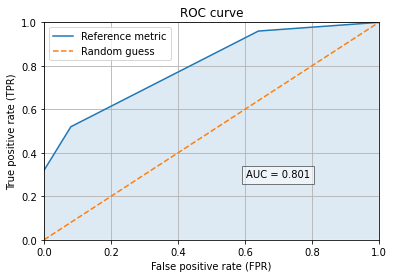

<Figure size 432x288 with 0 Axes>

In [47]:
ROCCurveReport.generate_report(
    metric_result=audit_results[0],
    inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
    show=True
)

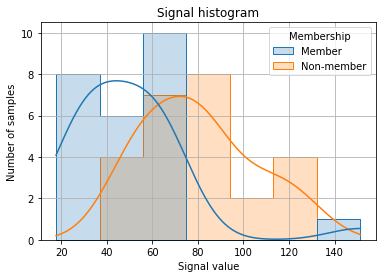

<Figure size 432x288 with 0 Axes>

In [49]:
SignalHistogramReport.generate_report(
    metric_result=audit_results[0][0],
    inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
    show=True
)